# SWB Regression Pipeline - Beta Power x CPE only
- Single Electrode Trial Averaged Regressions with Permutation Statistics
- Robust regression bdi ~ cpe regression coefficients for each ROI 
- ROI split mixed effects regressions (currently depreciated)

Created: 07/30/24 \
Updated: 09/30/2024 \
*ran with 1 sec regression dfs from 09/24/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2



In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



09302024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *



In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


# Load beta power data 

In [7]:
epoch_len = '1sec'
band = 'beta'

In [8]:
beta_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
beta_df.subj_id.unique()



array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [9]:
beta_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'ChoicePos', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'epoch', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type', 'cf',
       'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset',
       'reref_ch_names', 'band_pow', 'roi', 'hemi', 'unique_reref_ch'],
      dtype='object')

In [10]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()



roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [12]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     

keep_rois

['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [13]:
# ####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
# len(beta_reg_df)



# Electrode-wise Regressions + Permutations

In [14]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+cpe'
n_permutations = 1000


In [15]:
results_dict, main_var_sig = run_individual_elec_regression(beta_reg_df,reg_formula,elec_col, 
                                                            main_var,n_permutations)


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1713.01it/s]


In [33]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'cpe']

In [17]:
results = single_elec_permutation_results(results_dict,beta_reg_df,save_vars)
results



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TrialEV,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TrialEV,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TrialEV,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TrialEV,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,0.064149,-0.125736,0.039678,0.055964,-0.024102,0.001271,...,0.039925,0.039083,2.927494,-2.925486,0.999010,1.439540,0.003417,0.003439,0.317790,0.149998
1,MS002_lacas2-lacas3,MS002,acc,14,0.061676,-0.084418,0.014138,0.013787,0.003780,-0.001010,...,0.037216,0.036553,2.094529,-2.096183,0.340803,0.382778,0.036213,0.036066,0.733252,0.701884
2,MS002_lacas3-lacas4,MS002,acc,14,0.046616,-0.080427,0.027195,0.075847,-0.009089,-0.000498,...,0.036882,0.037056,1.995967,-1.988763,0.733448,1.965405,0.045938,0.046727,0.463285,0.049367
3,MS002_lacas4-lacas5,MS002,acc,14,0.004616,-0.016866,0.066977,0.033328,-0.006658,-0.000509,...,0.038640,0.036632,0.390918,-0.394043,1.776799,0.932016,0.695858,0.693549,0.075601,0.351328
4,MS002_lacas5-lacas6,MS002,acc,14,0.039467,-0.042821,-0.008527,0.020268,0.009079,0.000796,...,0.039227,0.037675,1.032361,-1.029276,-0.249591,0.516993,0.301903,0.303350,0.802903,0.605161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,0.028110,-0.002430,0.014861,0.023893,0.027740,0.000860,...,0.040394,0.033564,0.021490,-0.081041,0.313568,0.629531,0.982855,0.935409,0.753849,0.529001
1184,DA039_rpins2-rpins3,DA039,pins,22,0.059093,0.003231,0.000234,0.036195,0.061664,-0.001949,...,0.052227,0.042547,-0.117142,0.100649,0.007216,0.869163,0.906747,0.919829,0.994243,0.384758
1185,DA039_rpins3-rpins4,DA039,pins,22,-0.008920,-0.126236,-0.032976,0.056992,-0.058903,-0.002898,...,0.042778,0.038108,2.618023,-2.744953,-0.702859,1.477326,0.008844,0.006052,0.482144,0.139588
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,0.015667,-0.051362,0.029793,0.048601,-0.002261,-0.000759,...,0.039869,0.033968,1.035161,-1.246277,0.776875,1.378093,0.300594,0.212663,0.437232,0.168175


In [18]:
results.columns



Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TrialEV', 'Original_Estimate_cpe',
       'Permuted_Mean_Intercept', 'Permuted_Mean_GambleChoice[T.safe]',
       'Permuted_Mean_TrialEV', 'Permuted_Mean_cpe', 'Permuted_Std_Intercept',
       'Permuted_Std_GambleChoice[T.safe]', 'Permuted_Std_TrialEV',
       'Permuted_Std_cpe', 'Z_Score_Intercept', 'Z_Score_GambleChoice[T.safe]',
       'Z_Score_TrialEV', 'Z_Score_cpe', 'P_Value_Intercept',
       'P_Value_GambleChoice[T.safe]', 'P_Value_TrialEV', 'P_Value_cpe'],
      dtype='object')

### Save results as pickle file

In [19]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_CPE_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

In [20]:
# save_path = f'{save_dir}/{band}/'
# os.makedirs(save_path, exist_ok=True)

# fname = f'{save_path}{band}_perm_regression_results_{epoch_len}.pkl'
# pickle.dump(results, open(fname,"wb"))


In [21]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TrialEV,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TrialEV,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TrialEV,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TrialEV,P_Value_cpe
2,MS002_lacas3-lacas4,MS002,acc,14,0.046616,-0.080427,0.027195,0.075847,-0.009089,-0.000498,...,0.036882,0.037056,1.995967,-1.988763,0.733448,1.965405,4.593755e-02,4.672740e-02,0.463285,0.049367
16,MS002_laims5-laims6,MS002,ains,14,0.203611,-0.166374,-0.024301,0.137013,0.086334,0.001614,...,0.052941,0.050258,2.958266,-2.942887,-0.464647,2.726545,3.093746e-03,3.251670e-03,0.642185,0.006400
20,MS002_laims12-laims13,MS002,dmpfc,14,0.084569,-0.104177,-0.016053,0.081264,0.010583,0.001834,...,0.039581,0.040235,2.488585,-2.475644,-0.379415,2.033422,1.282526e-02,1.329962e-02,0.704380,0.042010
58,MS002_raims1-raims2,MS002,ains,14,0.347853,-0.425359,0.007473,0.131657,0.048860,0.004722,...,0.061490,0.057764,6.539478,-6.532572,0.101187,2.219465,6.173417e-11,6.464962e-11,0.919402,0.026455
60,MS002_raims3-raims4,MS002,ains,14,0.263819,-0.289747,0.000712,0.106630,0.063785,-0.002163,...,0.056574,0.051616,4.877127,-4.869592,0.035740,2.068537,1.076424e-06,1.118287e-06,0.971490,0.038590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,DA039_ram2-ram3,DA039,amy,22,-0.048618,0.011849,-0.025871,0.047504,-0.044783,0.000402,...,0.027801,0.023662,-0.314132,0.398498,-0.935162,2.036878,7.534211e-01,6.902632e-01,0.349705,0.041662
1179,DA039_rof8-rof9,DA039,dlpfc,22,0.045344,-0.096702,0.010877,0.079684,0.009017,-0.001317,...,0.046555,0.038825,1.767513,-1.972027,0.267936,2.018159,7.714228e-02,4.860657e-02,0.788748,0.043575
1180,DA039_rof9-rof10,DA039,dlpfc,22,0.023512,-0.017446,0.070845,0.114632,0.021419,0.000877,...,0.046833,0.037655,0.104232,-0.388480,1.502328,3.080821,9.169856e-01,6.976608e-01,0.133012,0.002064
1182,DA039_rof11-rof12,DA039,dlpfc,22,-0.010436,-0.056132,0.035270,0.040506,-0.029947,-0.001028,...,0.023677,0.019993,1.930796,-2.320649,1.541843,2.043488,5.350827e-02,2.030579e-02,0.123112,0.041004


In [22]:
sig_data.roi.value_counts()



roi
acc      24
ofc      19
ains     17
dlpfc    13
dmpfc    12
vlpfc    11
pins     10
amy       7
hpc       7
Name: count, dtype: int64

In [23]:
sig_data.roi.unique()



array(['acc', 'ains', 'dmpfc', 'hpc', 'amy', 'ofc', 'pins', 'vlpfc',
       'dlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [24]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TrialEV,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TrialEV,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TrialEV,P_Value_cpe,cpe_sig,bdi_split
0,MS002_lacas1-lacas2,MS002,acc,14,0.064149,-0.125736,0.039678,0.055964,-0.024102,0.001271,...,2.927494,-2.925486,0.999010,1.439540,0.003417,0.003439,0.317790,0.149998,0,0
1,MS002_lacas2-lacas3,MS002,acc,14,0.061676,-0.084418,0.014138,0.013787,0.003780,-0.001010,...,2.094529,-2.096183,0.340803,0.382778,0.036213,0.036066,0.733252,0.701884,0,0
2,MS002_lacas3-lacas4,MS002,acc,14,0.046616,-0.080427,0.027195,0.075847,-0.009089,-0.000498,...,1.995967,-1.988763,0.733448,1.965405,0.045938,0.046727,0.463285,0.049367,1,0
3,MS002_lacas4-lacas5,MS002,acc,14,0.004616,-0.016866,0.066977,0.033328,-0.006658,-0.000509,...,0.390918,-0.394043,1.776799,0.932016,0.695858,0.693549,0.075601,0.351328,0,0
4,MS002_lacas5-lacas6,MS002,acc,14,0.039467,-0.042821,-0.008527,0.020268,0.009079,0.000796,...,1.032361,-1.029276,-0.249591,0.516993,0.301903,0.303350,0.802903,0.605161,0,0


In [25]:
cpe_var = 'Z_Score_cpe'

In [26]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [27]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc    0.394478
vlpfc    0.553682
dmpfc    0.122788
ofc      0.053753
ains     1.104444
pins     0.664009
acc      0.270133
amy      0.007528
hpc      0.176142
Name: Z_Score_cpe, dtype: float64

In [28]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [29]:
roi_sig_info

,roi,n_total,n_sig,prop_sig,n_sig_highbdi,ttest_stat,ttest_pval,binom_ci_low,binom_ci_high,binom_prop,binom_pval
0,acc,193,24,0.124352,6,3.062595,2.509213e-03,0.087247,1.0,0.124352,0.0000
1,dmpfc,225,12,0.053333,2,1.786689,7.534009e-02,0.031059,1.0,0.053333,0.4513
2,amy,113,7,0.061947,1,0.069962,9.443490e-01,0.029432,1.0,0.061947,0.3362
3,ains,71,17,0.239437,1,6.595270,6.772847e-09,0.158677,1.0,0.239437,0.0000
4,vlpfc,82,11,0.134146,2,3.820429,2.600103e-04,0.077086,1.0,0.134146,0.0026
5,hpc,135,7,0.051852,2,1.936053,5.496664e-02,0.024586,1.0,0.051852,0.5154
6,ofc,202,19,0.094059,5,0.672291,5.021704e-01,0.062472,1.0,0.094059,0.0065
7,pins,60,10,0.166667,2,3.941766,2.169773e-04,0.093307,1.0,0.166667,0.0007
8,dlpfc,107,13,0.121495,6,3.591726,4.996055e-04,0.073384,1.0,0.121495,0.0027


In [30]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

,roi,n_total,n_sig,prop_sig,n_sig_highbdi,ttest_stat,ttest_pval,binom_ci_low,binom_ci_high,binom_prop,binom_pval
0,acc,193,24,0.124352,6,3.062595,2.509213e-03,0.087247,1.0,0.124352,0.0000
3,ains,71,17,0.239437,1,6.595270,6.772847e-09,0.158677,1.0,0.239437,0.0000
4,vlpfc,82,11,0.134146,2,3.820429,2.600103e-04,0.077086,1.0,0.134146,0.0026
6,ofc,202,19,0.094059,5,0.672291,5.021704e-01,0.062472,1.0,0.094059,0.0065
7,pins,60,10,0.166667,2,3.941766,2.169773e-04,0.093307,1.0,0.166667,0.0007
8,dlpfc,107,13,0.121495,6,3.591726,4.996055e-04,0.073384,1.0,0.121495,0.0027


# Plot Results

In [34]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_cpe_coeff_barplot_{epoch_len}.pdf'

ylabel = fr'${band}_{{zpow}} \sim cpe$'


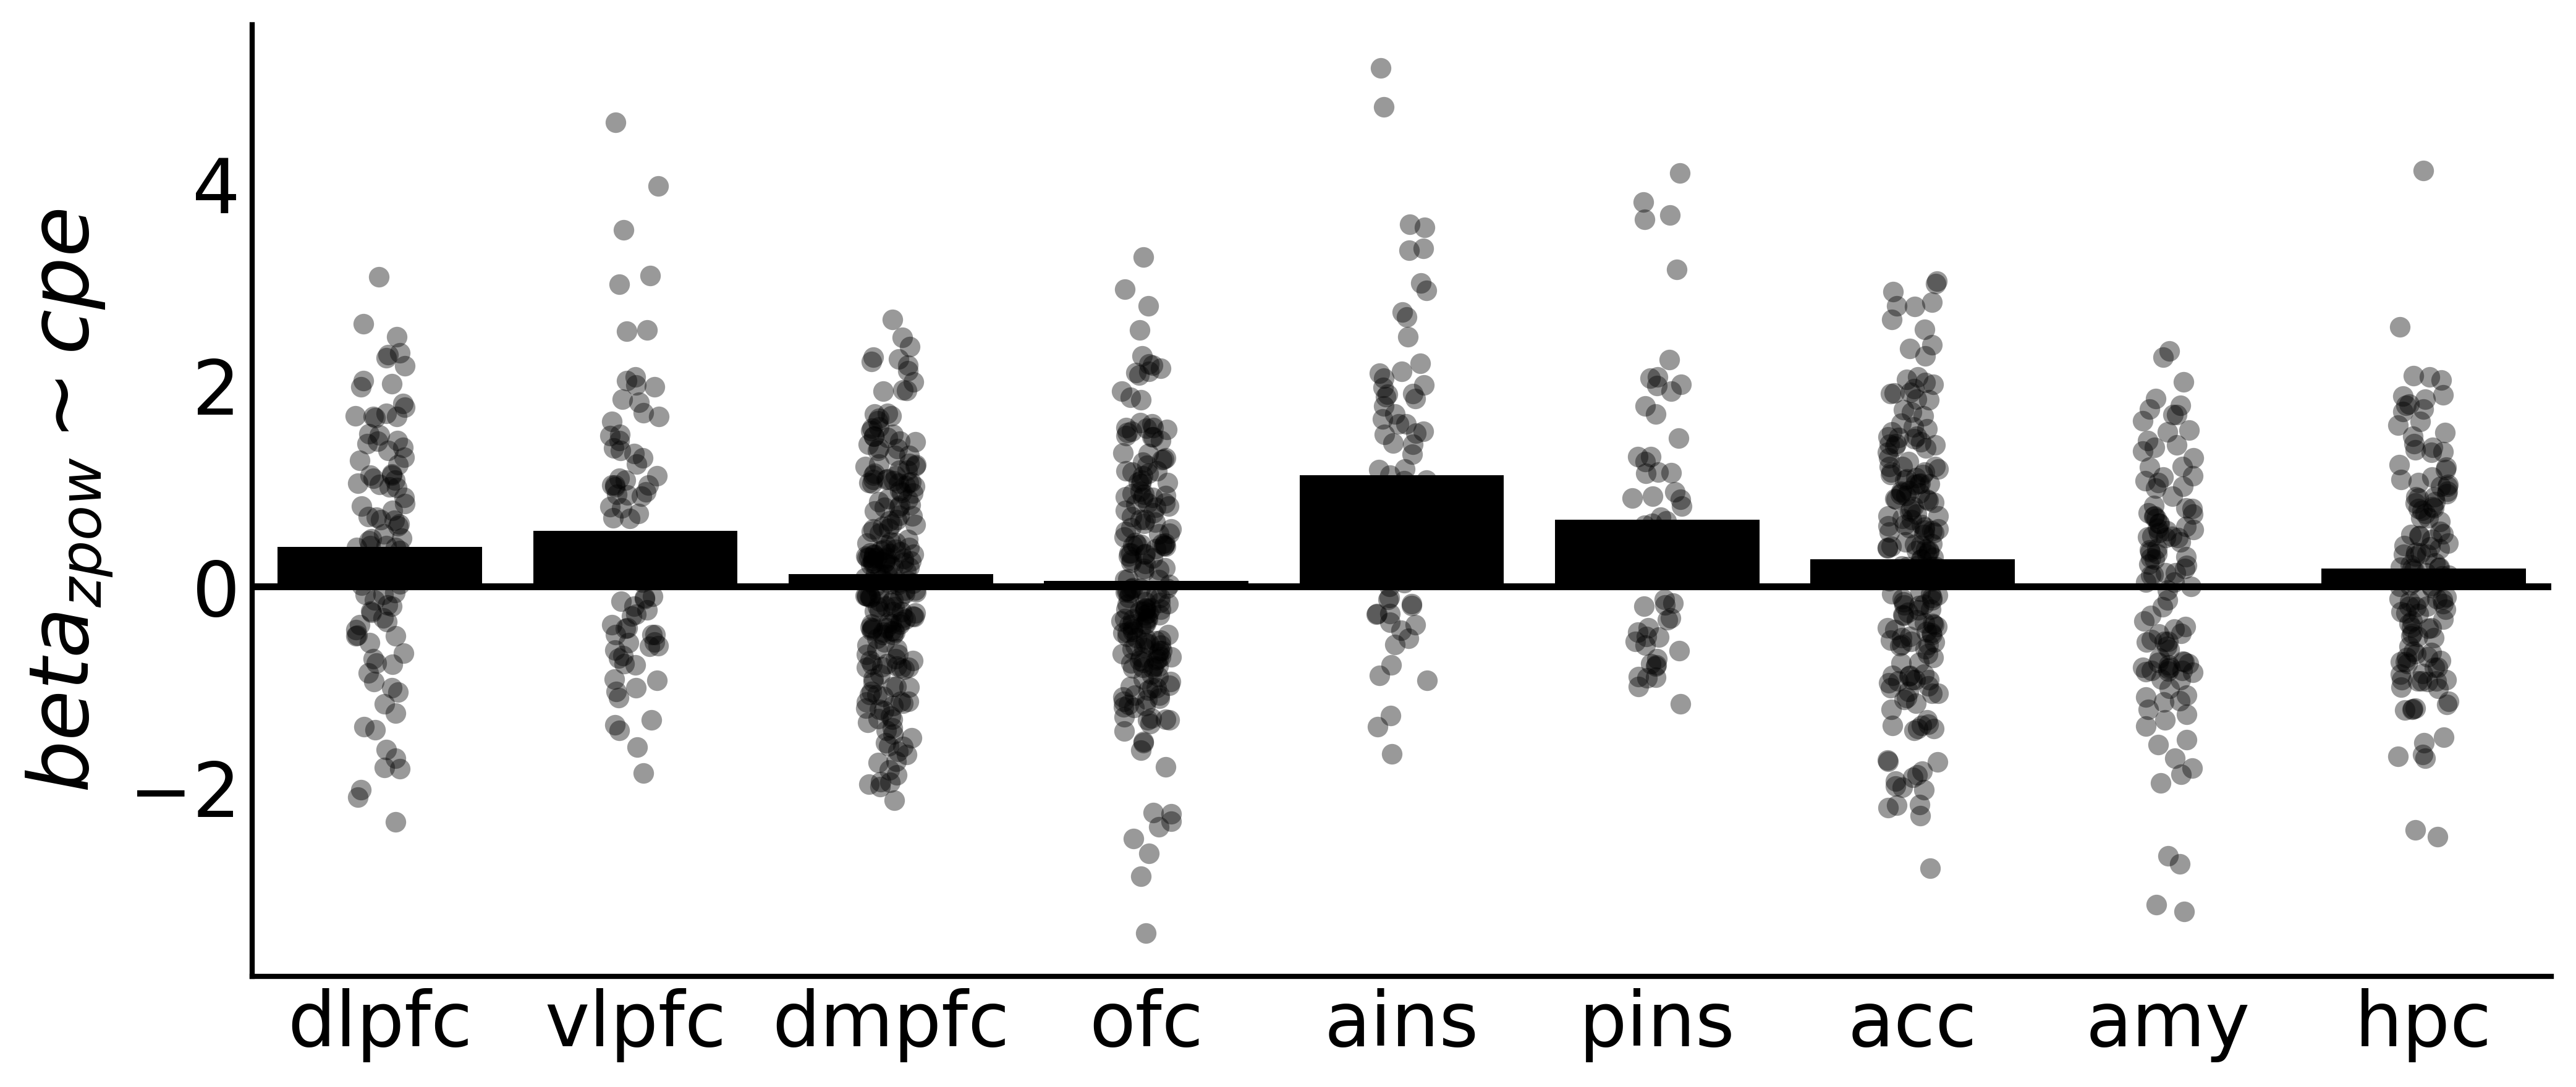

In [35]:
### WITHOUT RPE IN MODEL
plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

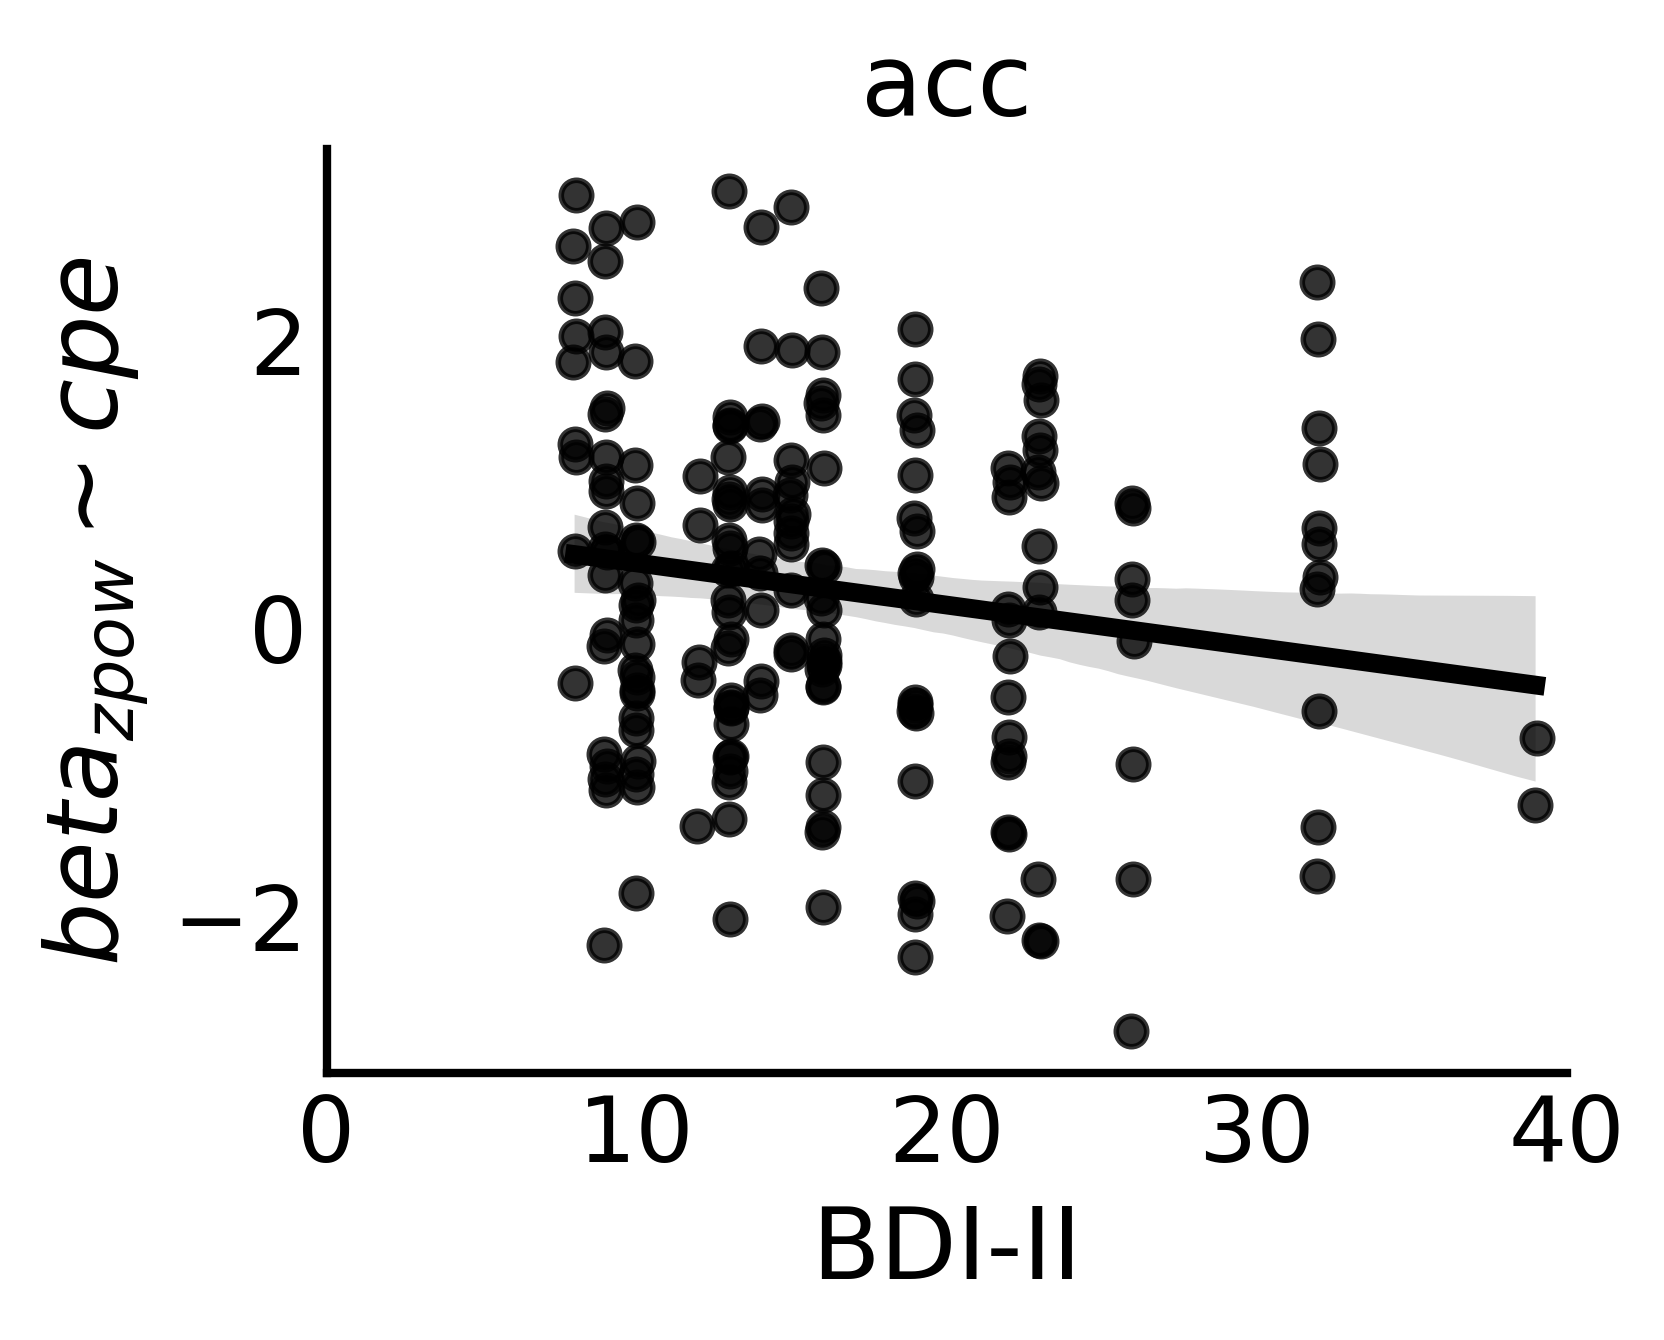

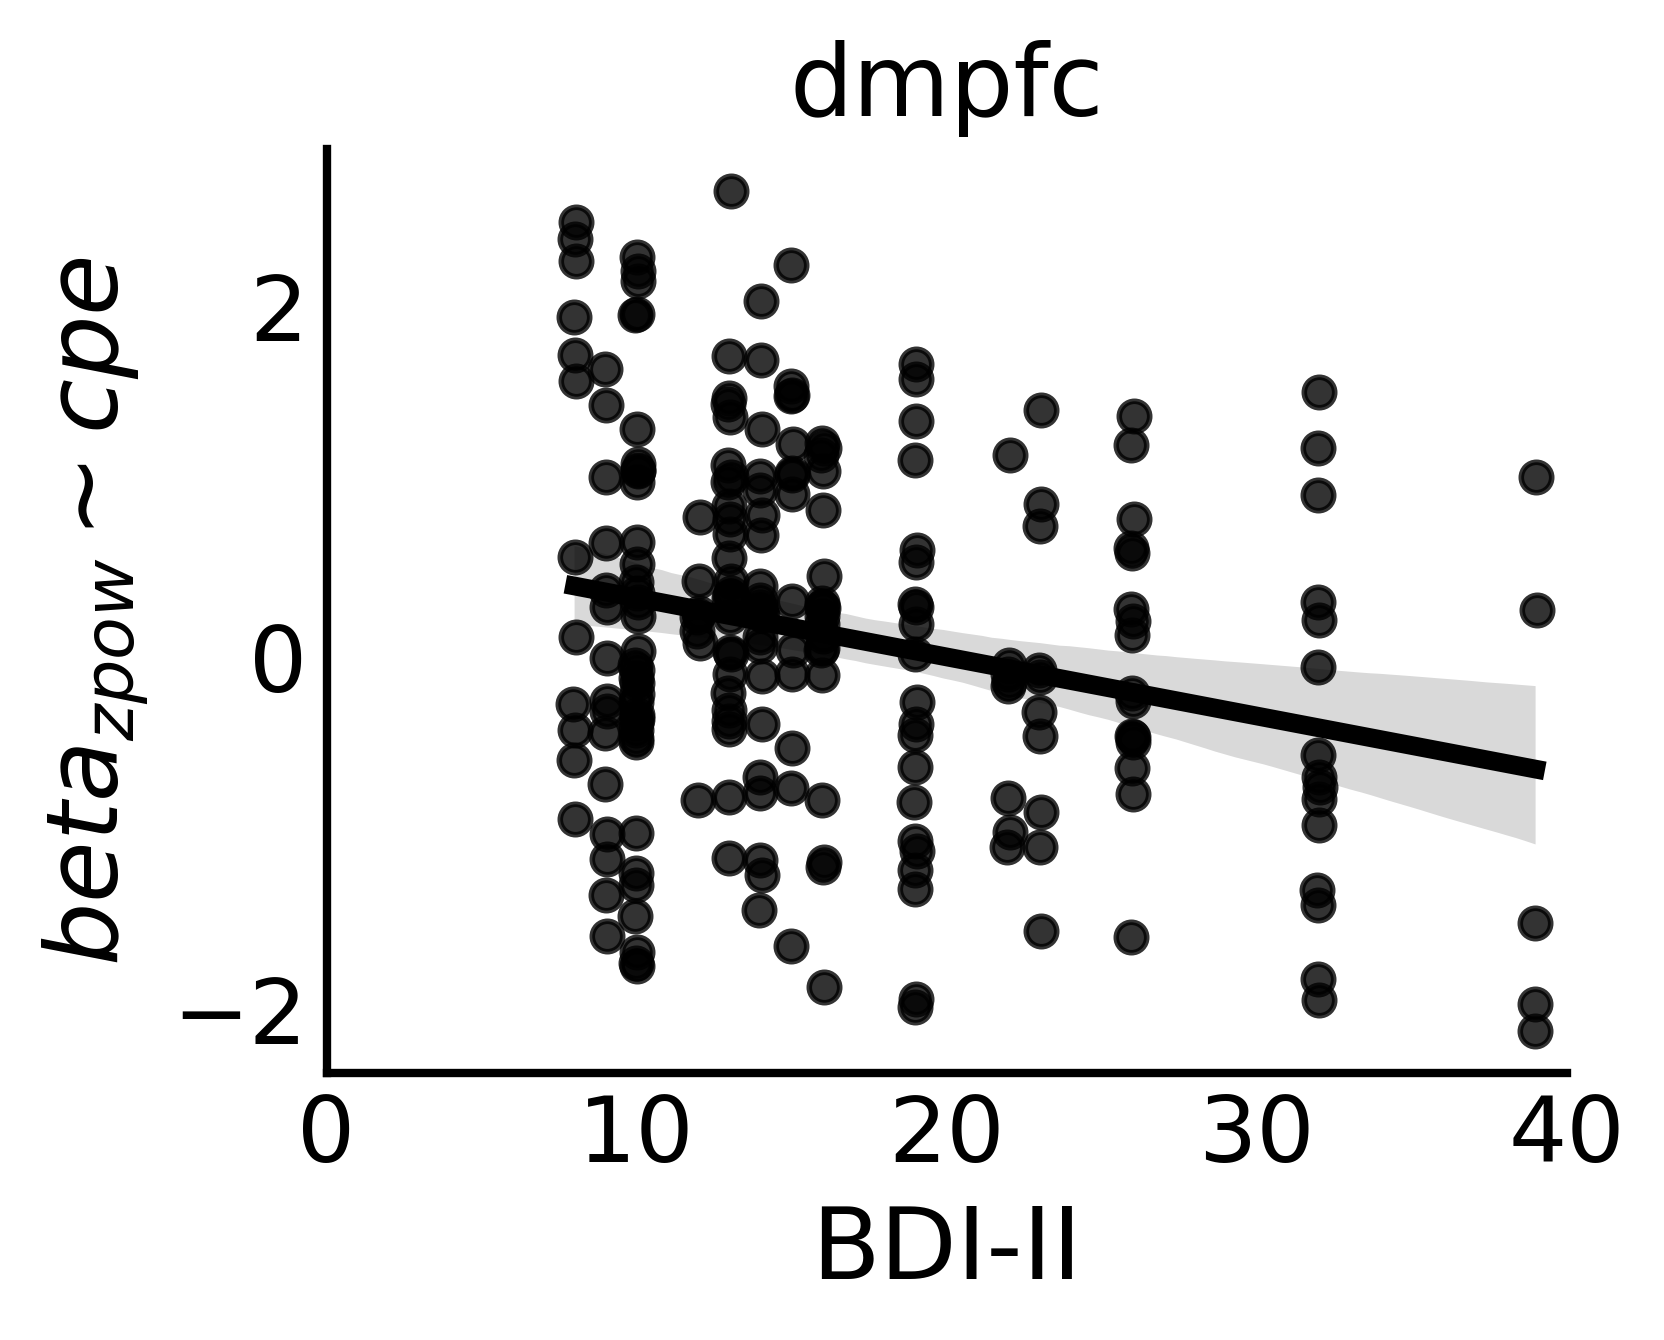

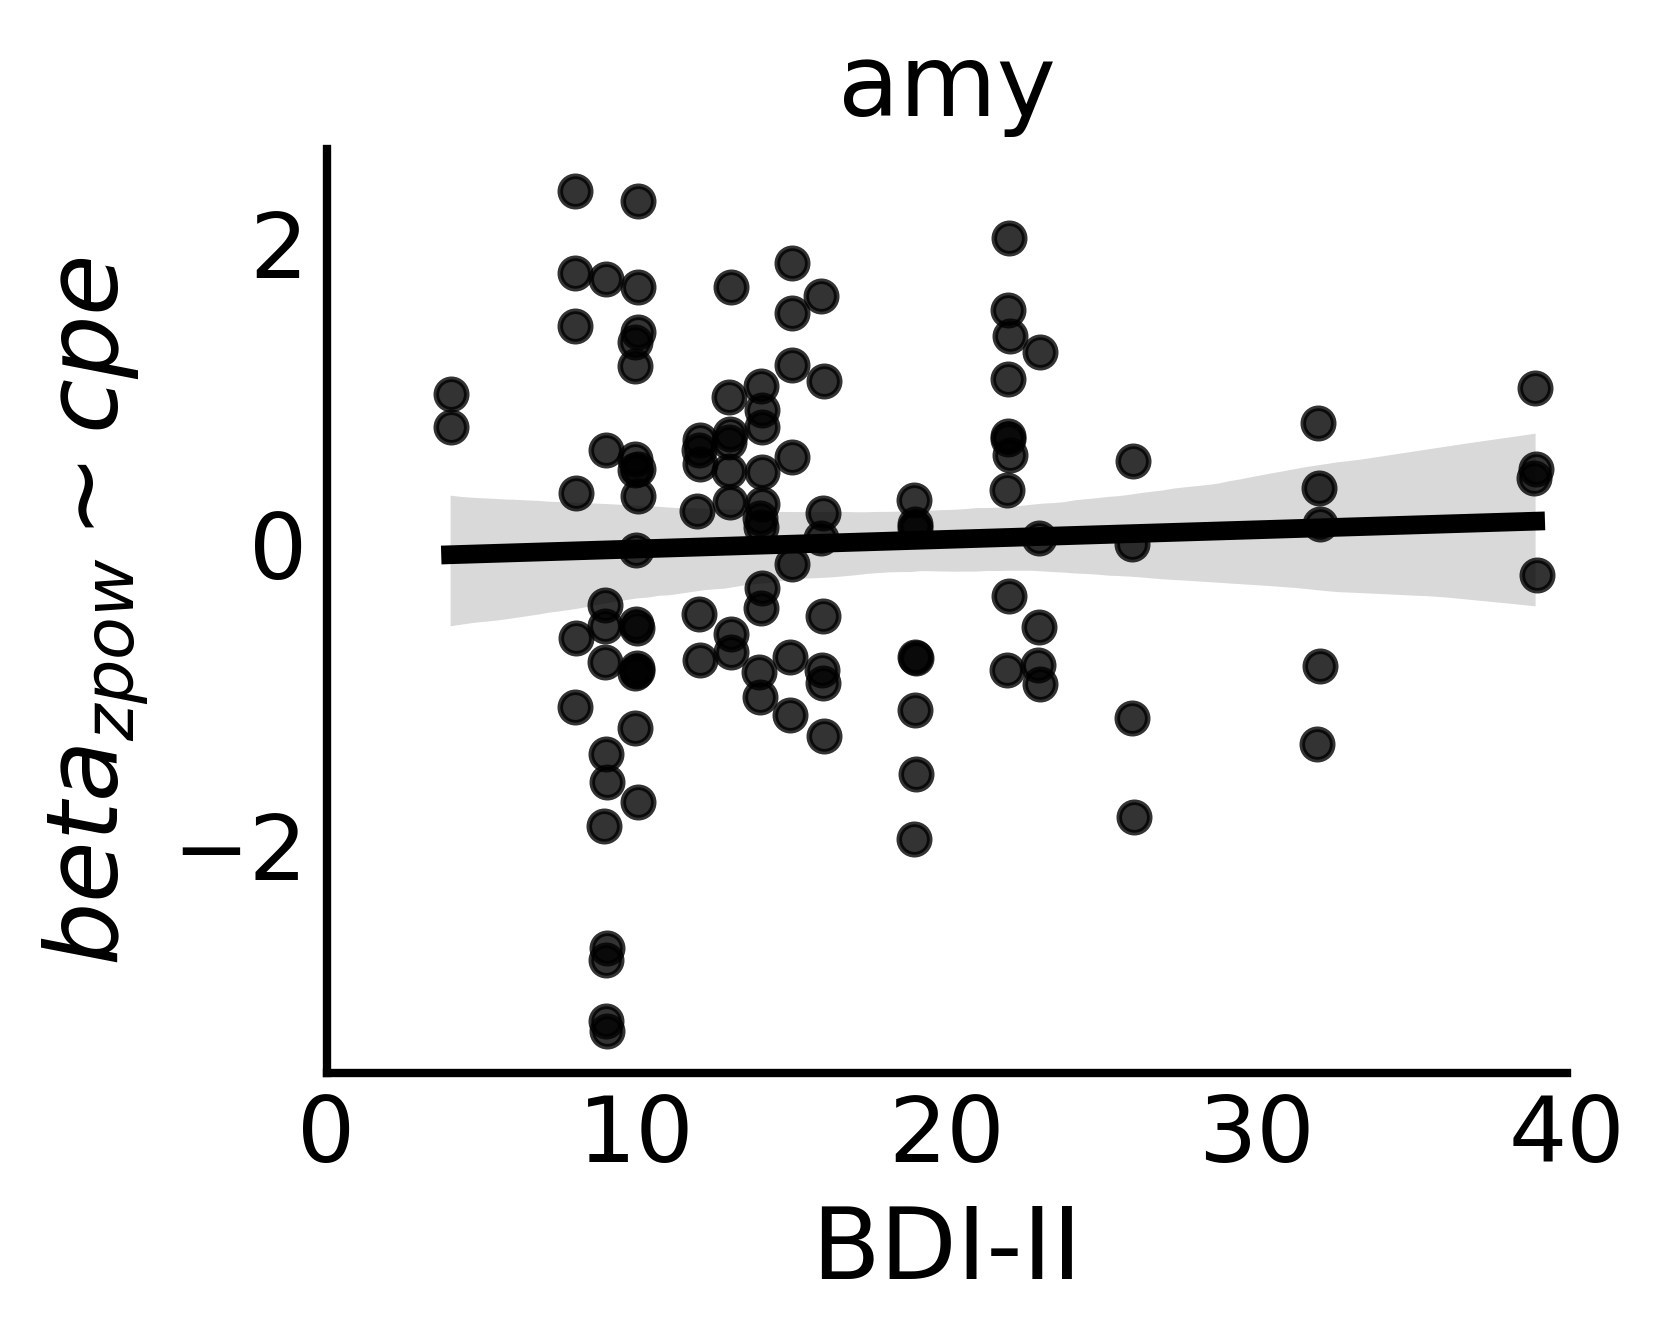

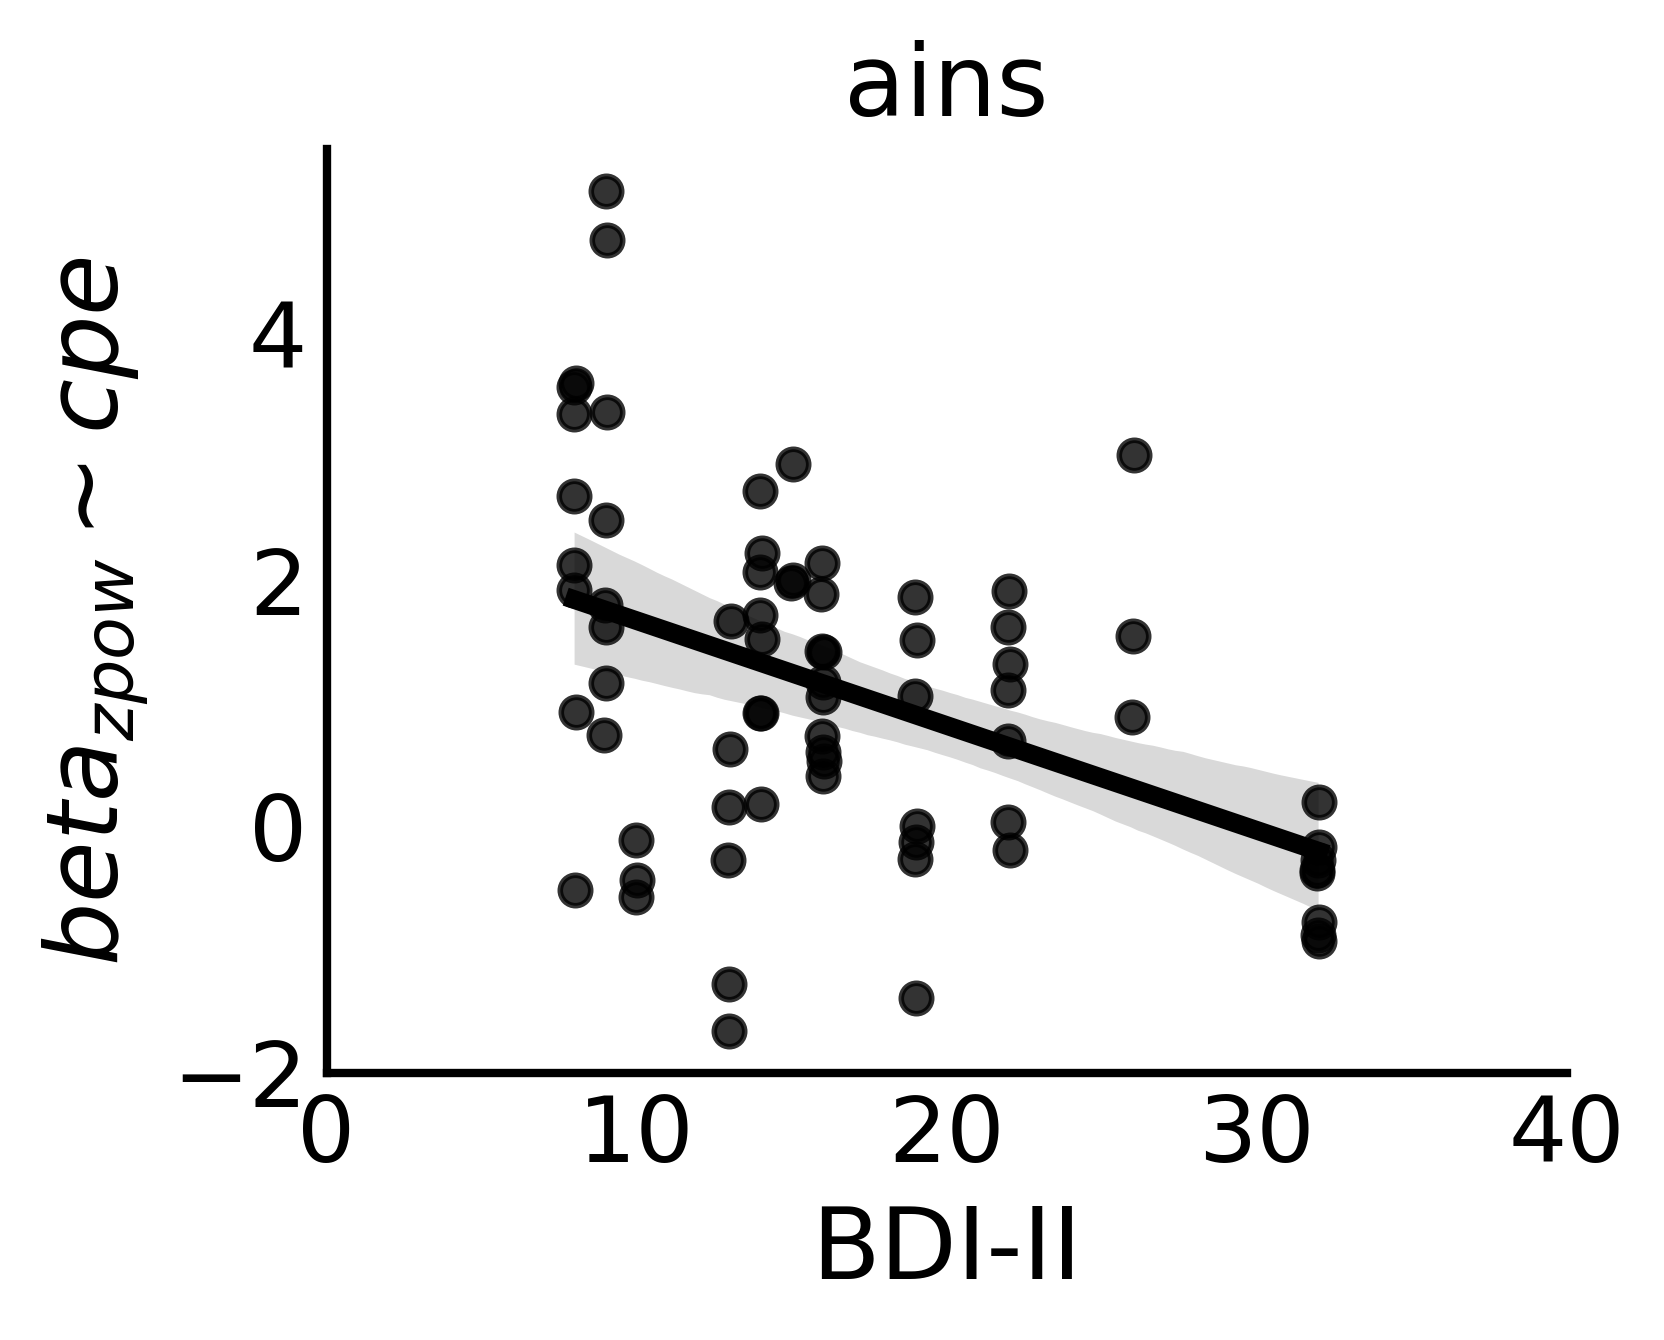

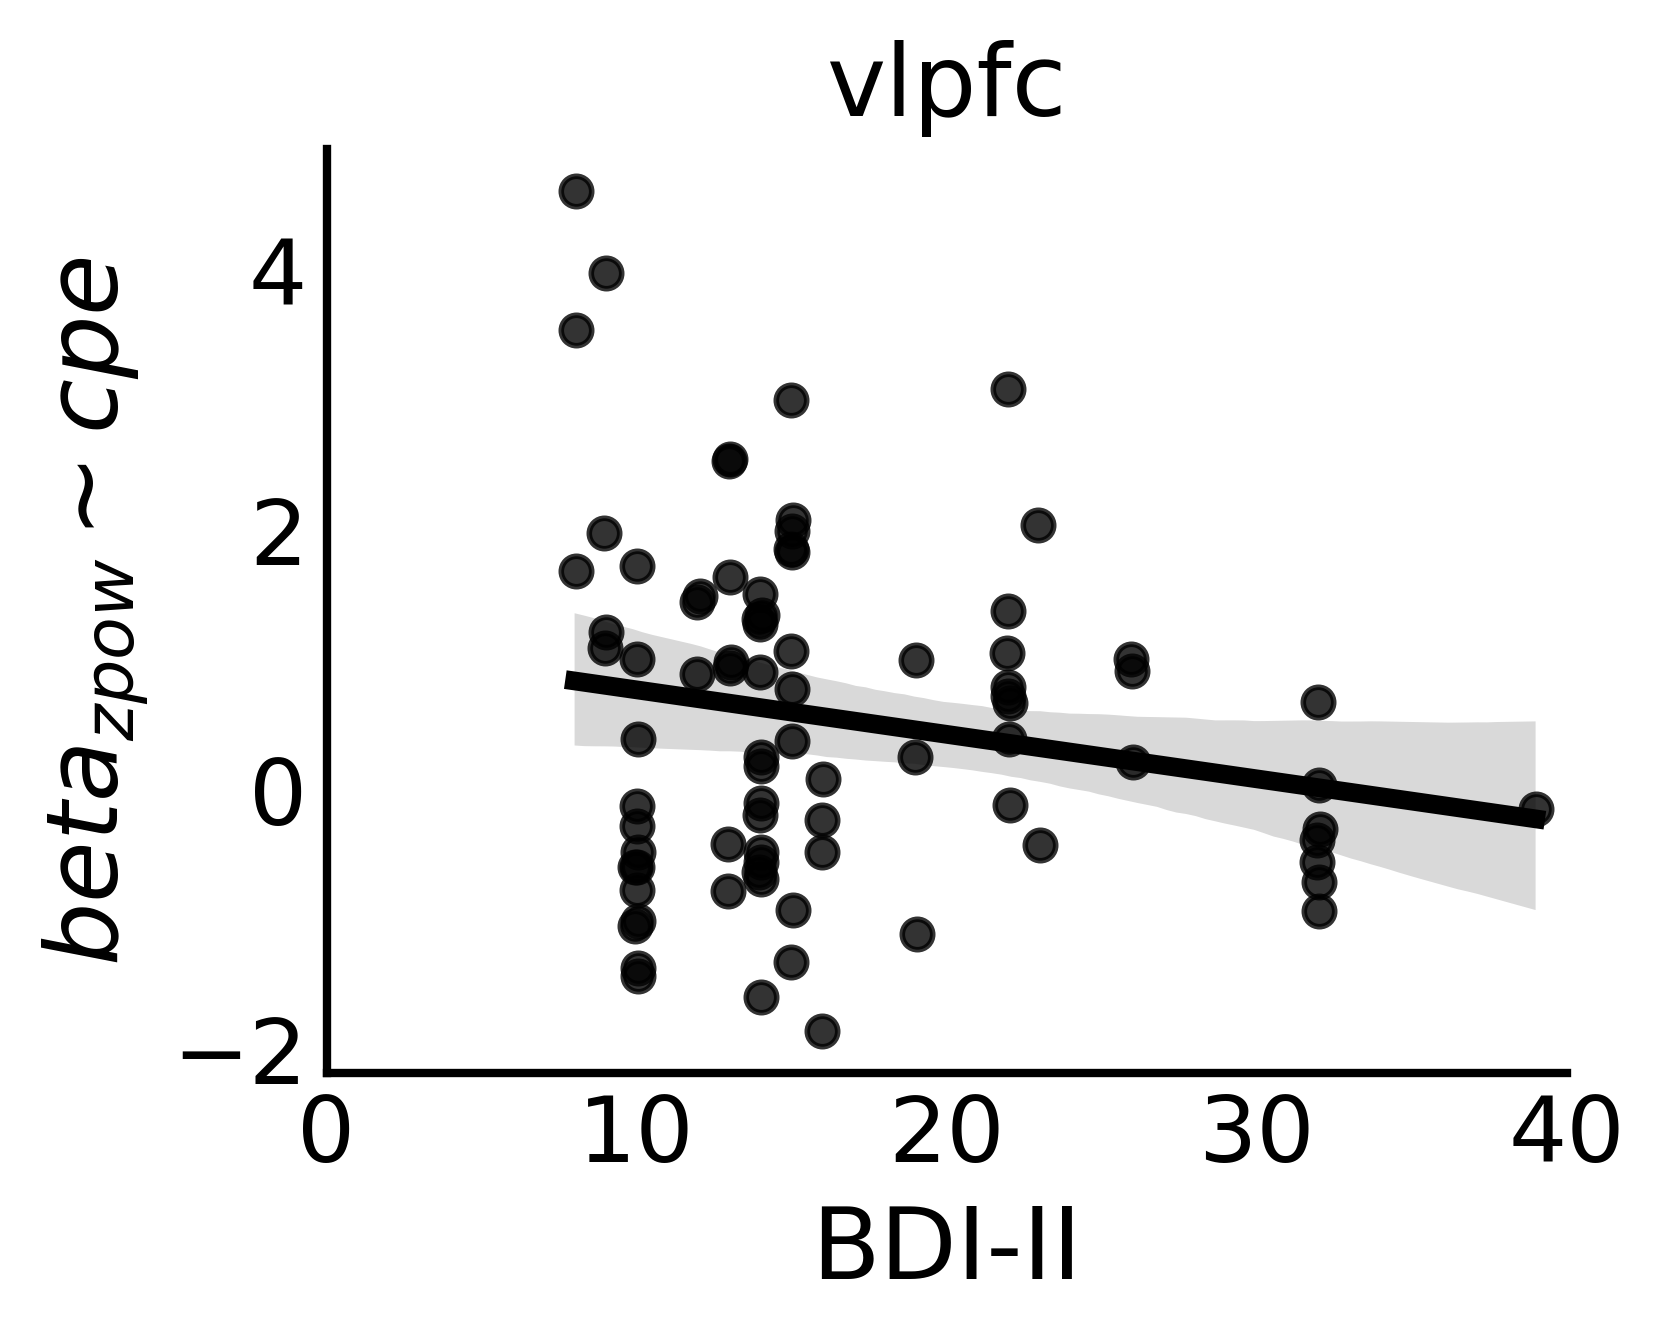

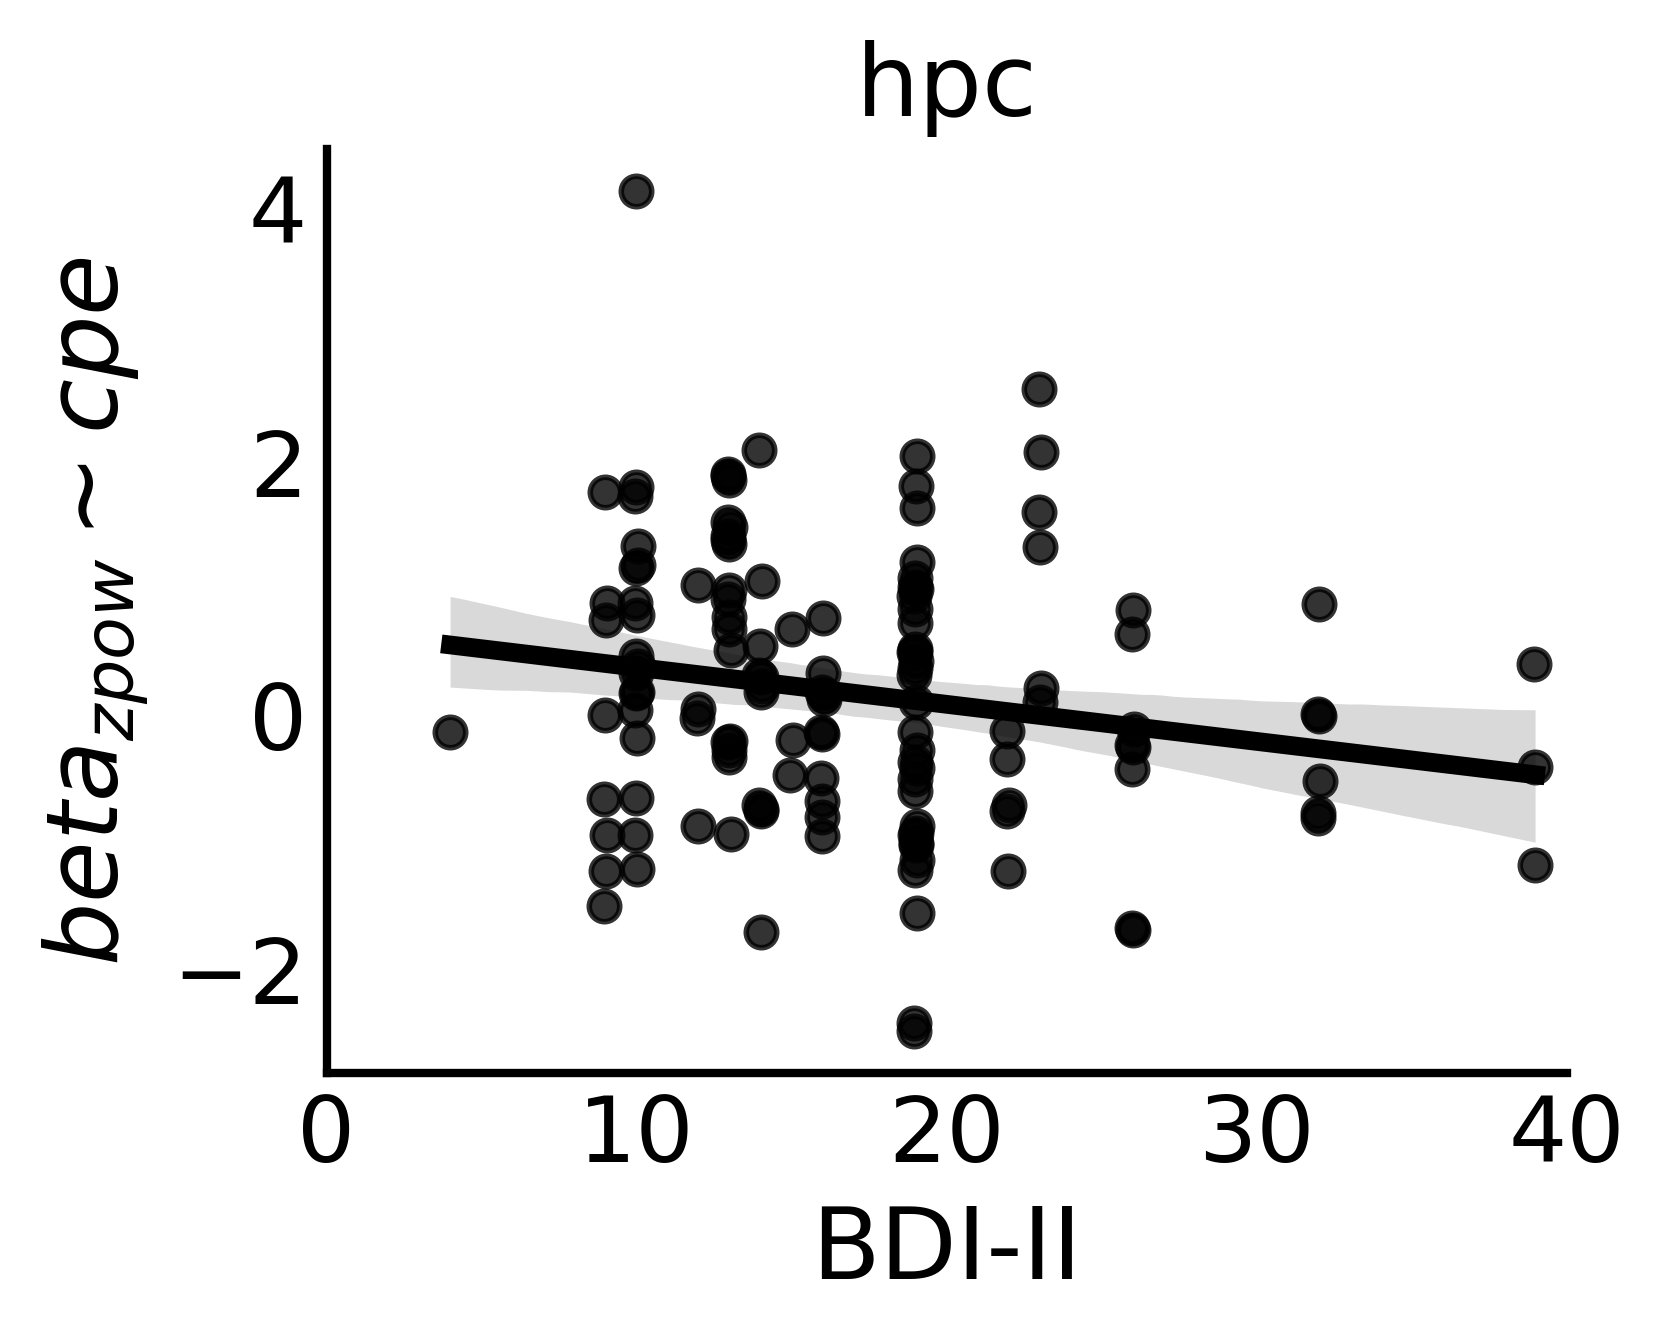

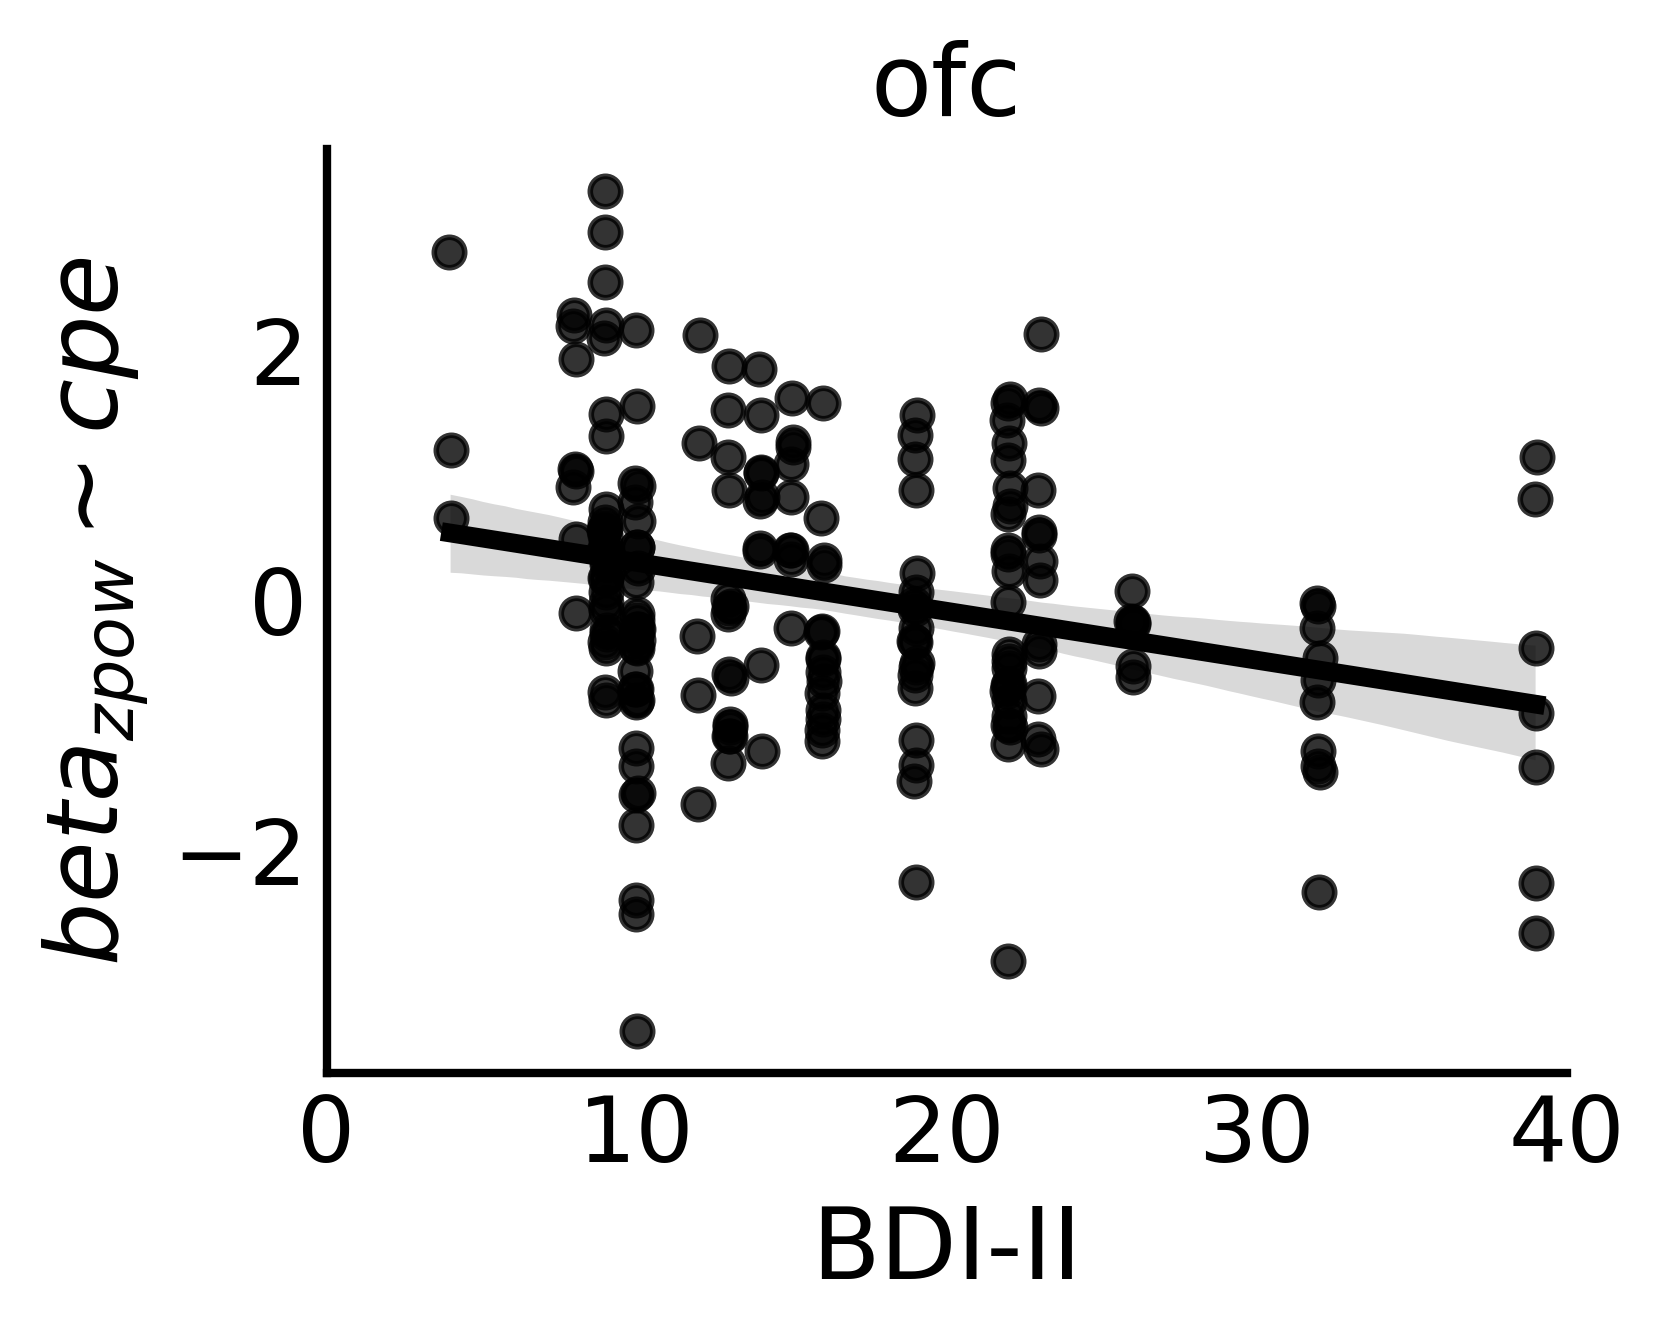

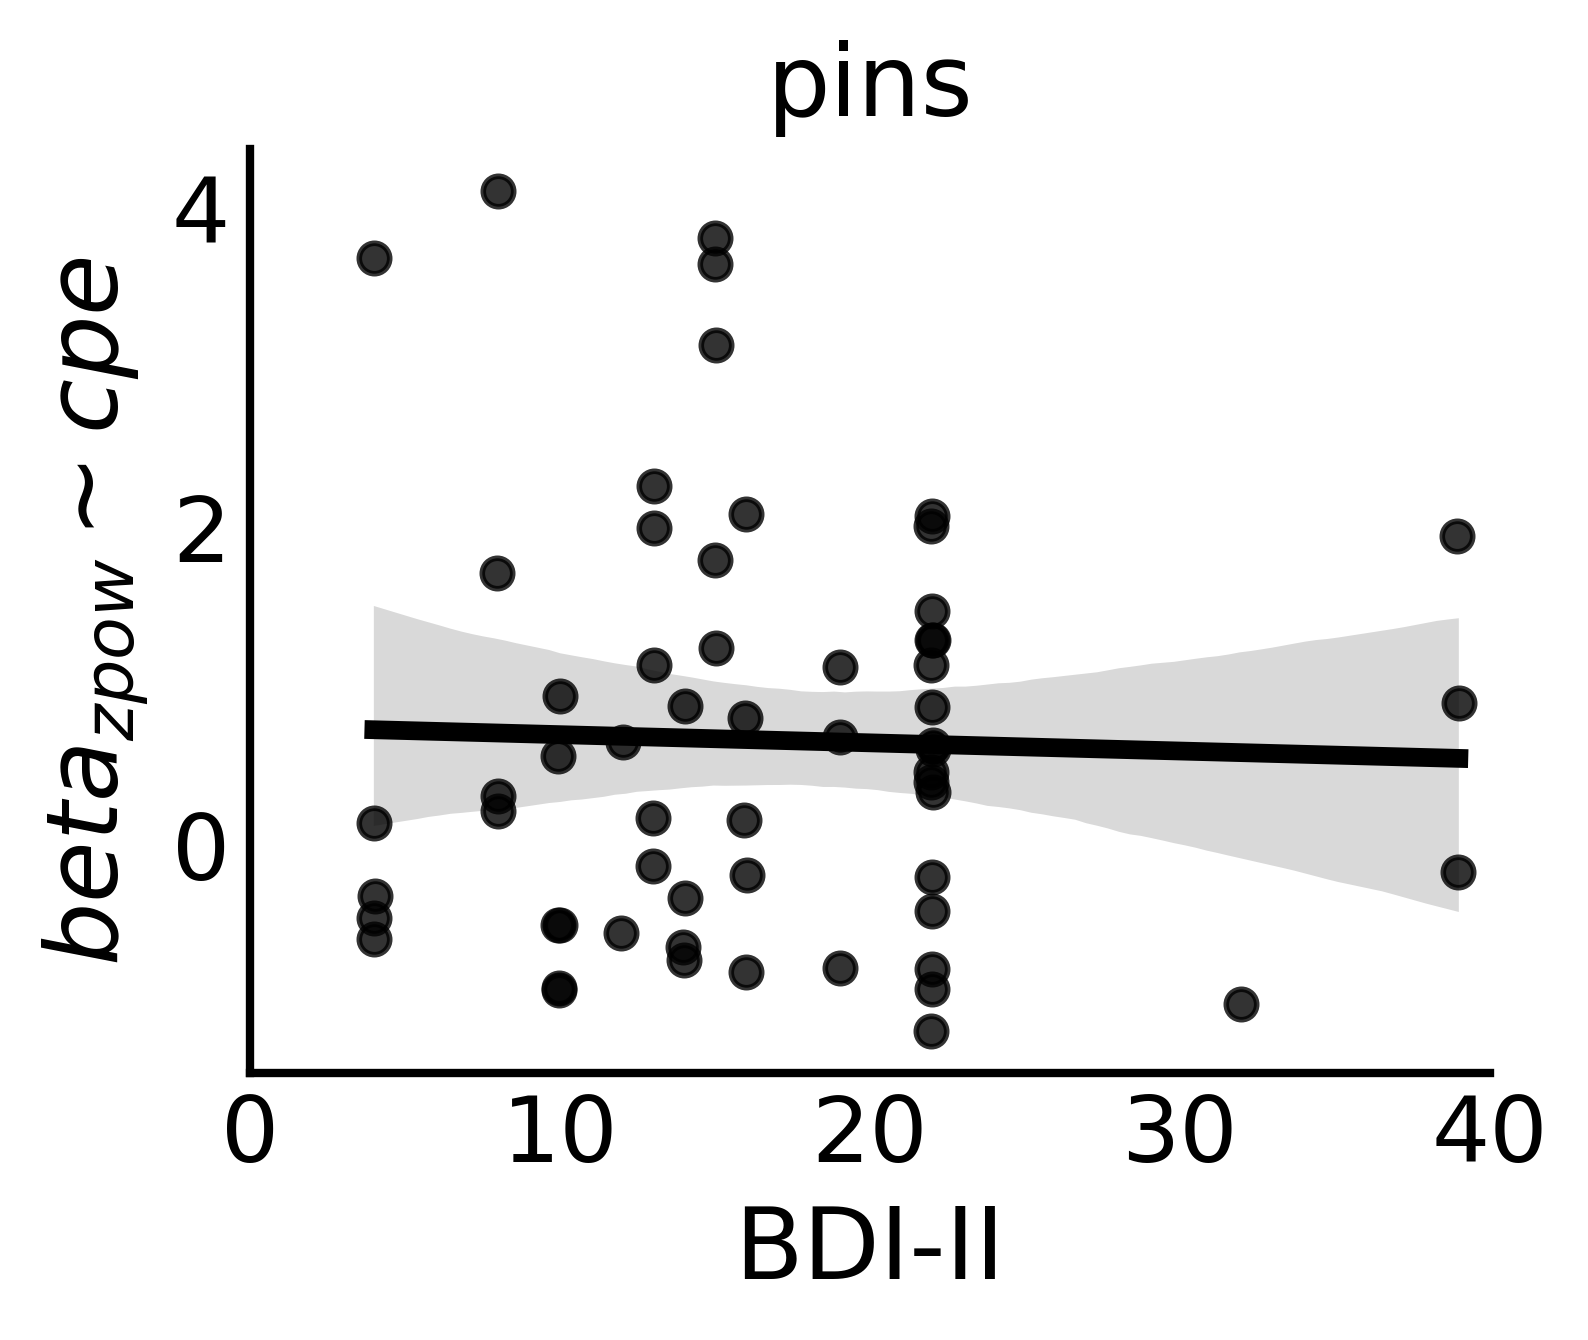

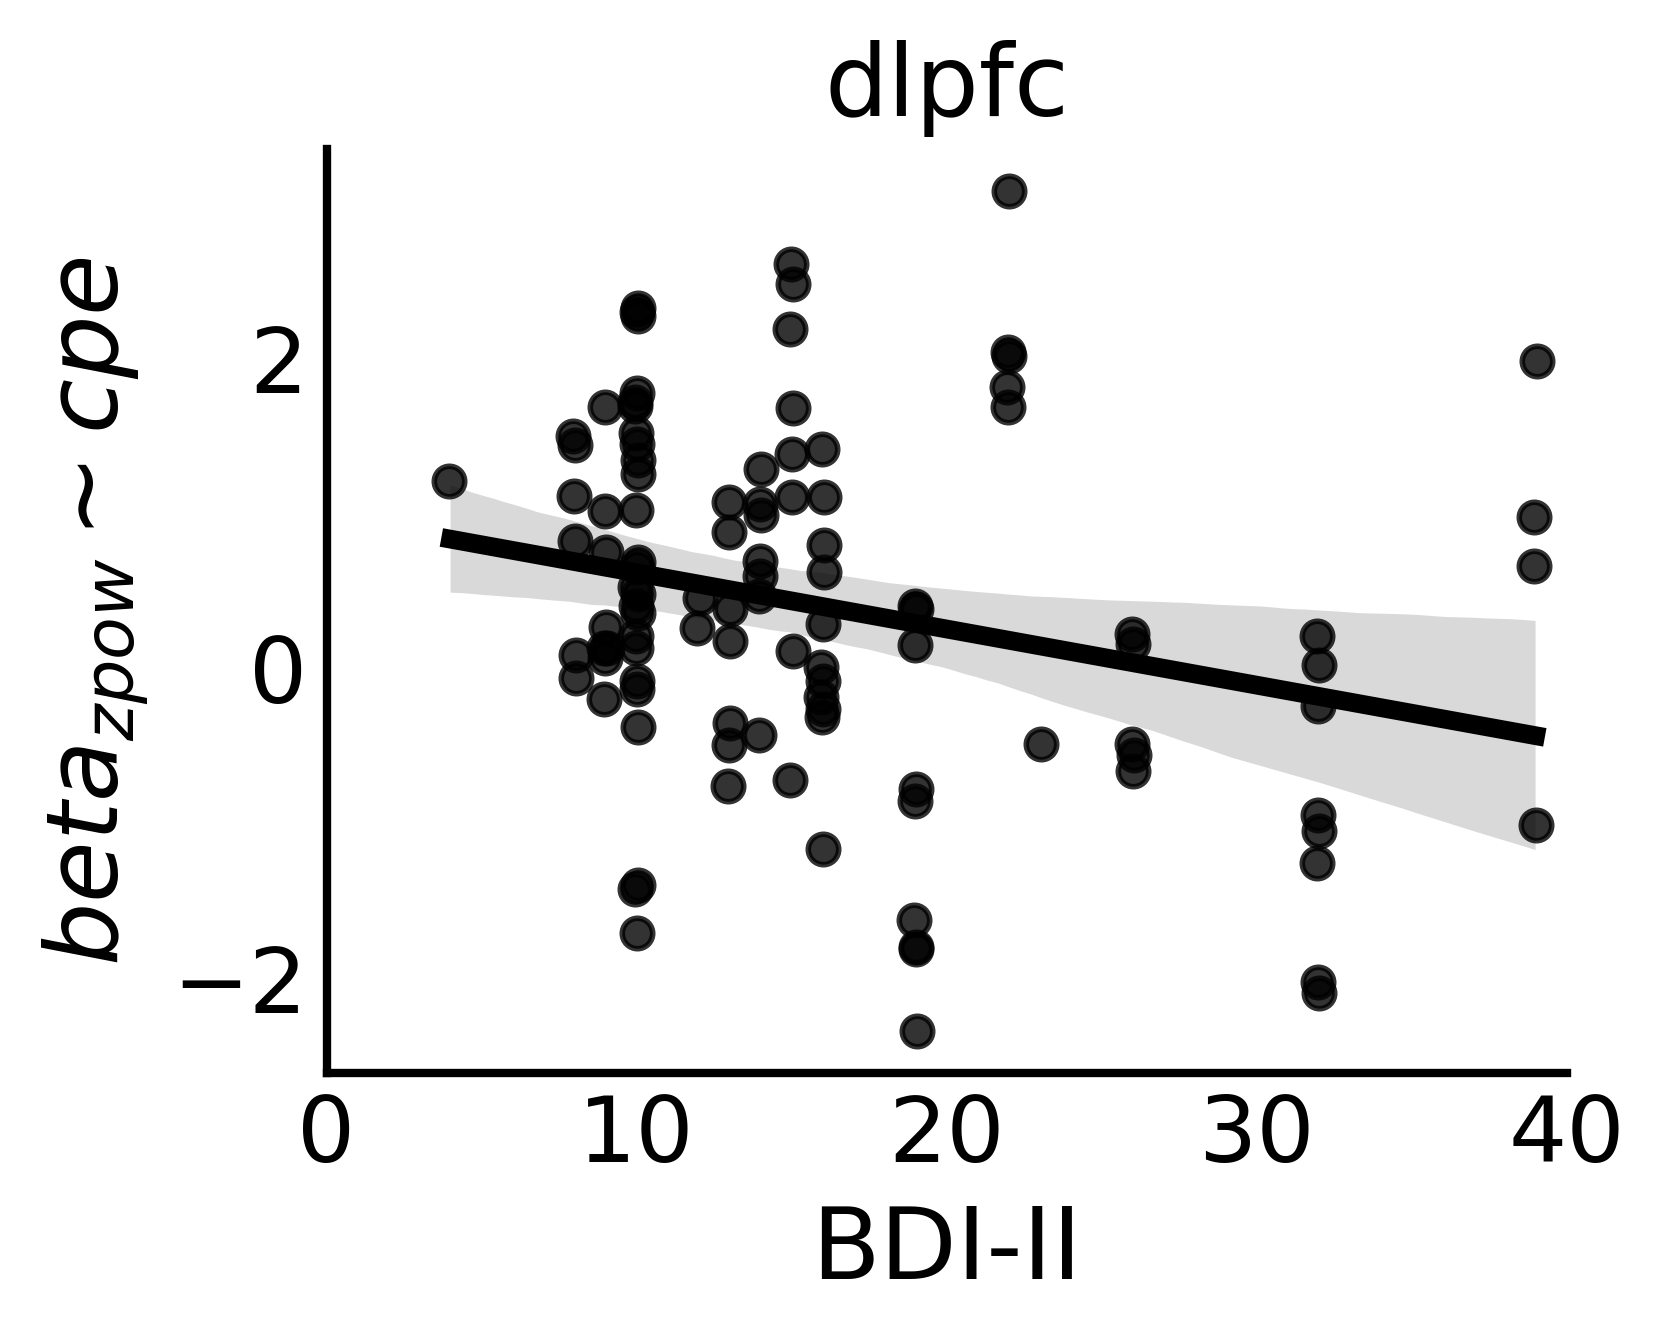

In [37]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [38]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        19:48:40                                         
No. Iterations:                    12                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9609      0.437     36.557     